##### Library Imports

In [91]:
import warnings
warnings.filterwarnings("ignore")

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
                                   PowerTransformer)
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier, early_stopping as lgbm_early_stopping
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

%matplotlib inline

# Predicting Churn for IBM Subscription Service

**Goals:**
1. Use subscription service data to determine key factors driving churn for *Telco*--a Telecommunications business.
2. Train a machine learning model to be able to predict customer churn for more targeted churn-reduction strategies.

**In this notebook:**
- Prepare training and test datasets
- Encode categorical features
- Scale numerical features
- Create model fit function with K-Fold on ROC-AUC scoring
    - CatBoost Model
    - XGBoost Model
    - LGBM Model
    - Stacking Ensemble Model
- Plot feature importance

In [7]:
df = pd.read_pickle("../data/telco_customer_churn_clean.pkl")
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure_binned,MonthlyCharges_binned,TotalCharges_binned,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,Low,Low,Low,False
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,Medium,Medium,Low,False
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Low,Medium,Low,True
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),Medium,Low,Low,False
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Low,Medium,Low,True


In [8]:
# Fix randomness in all utility packages with seed
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)

### Train/Test Split

In [100]:
TRAIN_TEST_RATIO = 0.8

# Split dataset into Training and Testing sets using train_test_split from Scikit Learn
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn']), df['Churn'], train_size=TRAIN_TEST_RATIO, random_state=SEED, stratify=df['Churn'], shuffle=True)
N_train, N_test = len(y_train), len(y_test)

print(f"Training set size: {N_train}\t\tTesting set size: {N_test}\n")
train_vc, test_vc = y_train.value_counts() / N_train * 100, y_test.value_counts() / N_test *100
print(f"Churn Distribution:\t\tYes\tNo\nTraining\t\t\t{train_vc.iloc[0]:.2f}%\t{train_vc.iloc[1]:.2f}%\nTesting\t\t\t\t{test_vc.iloc[0]:.2f}%\t{test_vc.iloc[1]:.2f}%")

# Get feature names
features = X_train.columns

Training set size: 5634		Testing set size: 1409

Churn Distribution:		Yes	No
Training			73.46%	26.54%
Testing				73.46%	26.54%


### Modeling

##### Helper Functions + BaseModel Class

In [101]:
class BaseModel:
    def __init__(self, model, model_name: str, seed: int):
        self.model = model
        self.model_name = model_name
        self.seed = seed
    
    def fit(self, X, y, X_test, y_test, n_splits, options):
        auc_scores = []
        test_predictions = None

        # Loop over train/validation folds
        folds = StratifiedKFold(n_splits=n_splits, random_state=self.seed, shuffle=True)
        for k, (train_indices, val_indices) in enumerate(folds.split(X, y)):
            # Extract X, y for training and validation
            X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
            X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]

            # Train the model on this fold
            auc = self.train(X_train, y_train, X_val, y_val, options)

            # Calculate ROC-AUC
            auc_scores.append(auc)

            # Print out AUC training score
            print(f"Fold\t{k+1}/{n_splits}\t\tTrain AUC Score={auc_scores[-1]:.2f}")

            preds = self.model.predict_proba(X_test)[:,1]
            test_predictions = preds if test_predictions is None else preds + test_predictions

        test_predictions /= n_splits
        test_auc_score = roc_auc_score(y_test, test_predictions)

        print(f"{self.model_name} Training Set".ljust(32), f"AUC Score\tmean={np.mean(auc_scores):.3f}\tstd={np.std(auc_scores):.3f}")
        print(f"{self.model_name} Testing Set".ljust(32), f"AUC Score\tmean={np.mean(test_auc_score):.3f}\tstd={np.std(test_auc_score):.3f}")

    def train(self, X_train, y_train, X_val, y_val, options):
        self.model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **options)
        return roc_auc_score(y_val, self.predict_proba(X_val)[:,1])
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def plot(self, importances, features):
        imp_df = pd.DataFrame({'feature': np.array(features), 'importance': np.array(importances)})
        imp_df.sort_values(by=['importance'], ascending=False, inplace=True)

        plt.figure(figsize=(10,8), dpi=100)
        sns.barplot(x=imp_df['importance'], y=imp_df['feature'])
        plt.title(f"{self.model_name} Feature Importances")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
        plt.savefig(f"../images/{self.model_name}_importances.png")

    def save(self):
        print('Saved model to file')

In [102]:
# XGBoost Model implementation
class XGBModel(BaseModel):
    def __init__(self, params, seed: int):
        super().__init__(model=XGBClassifier(**params), model_name="xgboost", seed=seed)

    def fit(self, X, y, X_test, y_test, n_splits):
        super().fit(X, y, X_test, y_test, n_splits, {"verbose": False})

    def save(self):
        self.model.save_model('../models/xgboost.json')

    def plot(self):
        return super().plot(self.model.feature_importances_, features)

# CatBoost Model implementation
# class CBModel(BaseModel):
#     def __init__(self, params, seed: int):
#         super().__init__(model=CatBoostClassifier(**params), model_name="catboost", seed=seed)
#     def fit(self, X, y, X_test, y_test, n_splits):
#         super().fit(X, y, X_test, y_test, n_splits, {})
#     def plot(self):
#         return super().plot(self.model.get_feature_importances(), features)
#     def save(self):
#         self.model.save_model('../models/catboost')

# CatBoost Model implementation
class LGBMModel(BaseModel):
    def __init__(self, params, seed: int):
        super().__init__(model=LGBMClassifier(**params), model_name="lightgbm", seed=seed)

    def fit(self, X, y, X_test, y_test, n_splits):
        super().fit(X, y, X_test, y_test, n_splits, {'eval_metric': 'auc', 'callbacks': [lgbm_early_stopping(200, verbose=False)]})

    def plot(self):
        return super().plot(self.model.feature_importances_, features)

    def save(self):
        self.model.booster_.save_model('../models/lightgbm.text')

##### One-off Training

Fold	1/10		Train AUC Score=0.82
Fold	2/10		Train AUC Score=0.84
Fold	3/10		Train AUC Score=0.85
Fold	4/10		Train AUC Score=0.83
Fold	5/10		Train AUC Score=0.82
Fold	6/10		Train AUC Score=0.84
Fold	7/10		Train AUC Score=0.84
Fold	8/10		Train AUC Score=0.85
Fold	9/10		Train AUC Score=0.83
Fold	10/10		Train AUC Score=0.81
xgboost Training Set             AUC Score	mean=0.835	std=0.011
xgboost Testing Set              AUC Score	mean=0.829	std=0.000


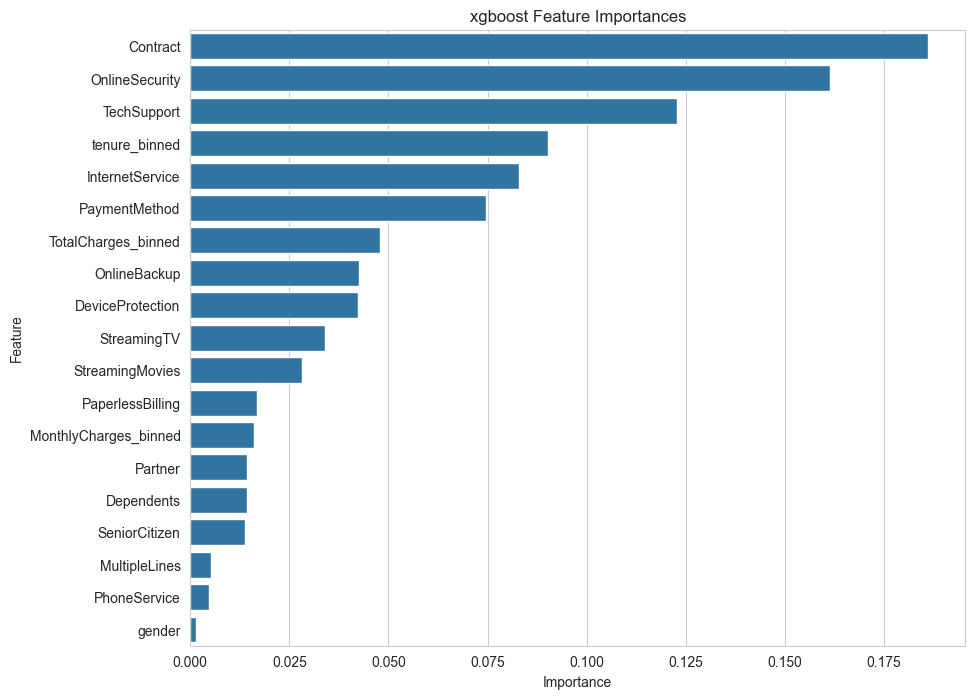

<Figure size 640x480 with 0 Axes>

In [104]:
n_splits=10
params = {
    'random_state': SEED,
    'colsample_bytree': 0.25,
    'max_depth': 3,
    'learning_rate': 1.8e-3,
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'gamma': 0,
    'n_estimators': 10000,
    'reg_lambda': 0.1,
    'subsample': 0.70,
    'enable_categorical': True
}

xgboost = XGBModel(params, SEED)
xgboost.fit(X_train, y_train, X_test, y_test, n_splits)
xgboost.plot()

In [94]:
n_splits=10
params  = {
    'random_state': SEED,
    'colsample_bylevel': 1.3e-2,
    'depth': 6,
    'learning_rate': 5.5e-2,
    'eval_metric': "AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian', 
    'iterations': 6888,
    'random_strength': 18, 
    'l2_leaf_reg': 50,
}

catboost = CBModel(params, SEED)
catboost.fit(X_train, y_train, X_test, y_test, n_splits)

NameError: name 'CBModel' is not defined

In [99]:
n_splits=10
params = {
    'random_state': SEED,
    'n_estimators': 12749, 
    'learning_rate': 0.2, 
    'reg_alpha': 9.8, 
    'reg_lambda': 5.0, 
    'max_depth': 56, 
    'num_leaves': 921, 
    'min_child_samples': 85, 
    'cat_smooth': 92,
    'colsample_bytree': 0.43, 
    'min_data_per_group': 59,
    'cat_l2': 17,
}
lightgbm = LGBMModel(params, SEED)
lightgbm.fit(X_train, y_train, X_test, y_test, n_splits)
lightgbm.plot()

[LightGBM] [Info] Number of positive: 1345, number of negative: 3725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 5070, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265286 -> initscore=-1.018673
[LightGBM] [Info] Start training from score -1.018673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
xgboost.plot()

##### Optuna Hyperparameter Optimization